Code to generate Figure 8 in 'Rethinking Discount Regularization'

# Imports

In [ ]:
import matplotlib.pyplot as plt
from pandas import DataFrame
import torch
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from statistics import mean
import time
import pickle

# Environment: Random Chain

In [ ]:
def random_chain():

  """ Random MDP from "The Dependence of Effective Planning Horizonon Model Accuracy"

    Nan Jiang, Alex Kulesza, Satinder Singh, and Richard Lewis

    Generate new MDP for each iteration.

    For each state-actionpair(s,a), the distribution over the next state,P(s,a,·), isdetermined by choosing 5 non-zero entries uniformly from all  10  states,
      filling  these  5  entries  with  values  uniformlydrawn  from[0,1],  and  finally  normalizing P(s,a,·).

    The mean rewards were likewise sampled uniformly and indepen-dently from[0,1], and the actual reward signals have additive Gaussian noise with standard deviation 0.1.  --> WE ASSUME R KNOWN

    For all MDPs we fixedγeval= 0.99.

  """
  num_states = 10
  num_nonzeros_states = 5
  num_actions = 2
  T_list = []
  for a in range(num_actions):
    T = np.zeros((num_states,num_states))
    for state in range(num_states):
      nonzero_states = random.sample(range(num_states),num_nonzeros_states)
      for n in nonzero_states:
        T[state][n] = np.random.uniform(0,1,1)
      total_prob = sum(T[state])
      T[state] = T[state]/total_prob
    T_list.append(np.array(T))

  R = np.random.uniform(0,1,num_states)
  #R1 = np.zeros((num_actions,num_states))
  #R1[0][0]=1
  #R = R+R1

  return np.array(T_list),np.array([R,R])

# Helper Functions

In [ ]:
def get_index (s,a):
  """helper fucntion to get (s,a) index
  """
  return s*num_actions+a

def greedy_policy(Q_sa,num_states,num_actions):
  """helper function to get greedy policy pi from Q_pi
  """

  Q_sa_unflattened = Q_sa.reshape(num_states,num_actions)
  pi = np.argmax(Q_sa_unflattened,axis=1)
  return pi

def pi_to_matrix(pi_actions):
  pi = np.zeros((num_states*num_actions,num_states))
  for s in range(num_states):
    sa = int(s*num_actions+pi_actions[s])
    pi[sa][s] = 1
  return pi

# Generate Data

In [ ]:
def gen_tuple(T_list,R_list,start_state_weights,action_weights):

    num_states = T_list[0].shape[0]
    num_actions = len(T_list)
    all_actions = range(num_actions)

    obs_rewards = [ [] for i in range(num_states)]

    actions = []

    all_states = range(num_states)
    state = np.random.choice(all_states,1,True,start_state_weights)[0]  # start at random state with uniform prob

    # choose random action
    action = np.random.choice(all_actions,p=action_weights)

    for a in all_actions:
      if action == a:
        t_probs = T_list[a][state].tolist()
    cum_tprobs = np.cumsum(t_probs)
    rand_num = np.random.uniform()
    for j in range(num_states):
      if rand_num < cum_tprobs[j]:
        next_state = j
        break

    reward = R_list[action][state].item()
    return (state,action,reward,next_state)


#gen dataset of trajectories
def gen_data(num_tuples,T_list,R_list,start_state_weights,exact=False):

    num_states = T_list[0].shape[0]
    num_actions = len(T_list)
    all_actions = range(num_actions)

    act_weights = [1./num_actions for n in range(num_actions)]

    data_tuples = []

    if exact == False:

        for i in range(num_tuples):
            s,a,r,s_prime = gen_tuple(T_list,R_list,start_state_weights,act_weights)
            data_tuples.append((s,a,r,s_prime))

    else:
        start_state_nums = [int(u*num_tuples/num_actions) for u in start_state_weights]
        for state in range(num_states):

            start_state_weights_exact= np.zeros(num_states)
            start_state_weights_exact[state] = 1

            for a in range(num_actions):
                act_weights = np.zeros(len(T_list))
                act_weights[a] = 1

                for j in range(start_state_nums[state]):
                    s,a,r,s_prime = gen_tuple(T_list,R_list,start_state_weights_exact,act_weights)
                    data_tuples.append((s,a,r,s_prime))

    return data_tuples

In [ ]:
def tuples_to_count_array(tuple_data,num_states,num_actions):
  count_data = np.zeros((num_states*num_actions,num_states))
  for s,a,r,s_prime in tuple_data:
    sa_idx = get_index(s,a)
    count_data[sa_idx][s_prime] += 1

  return np.asarray(count_data)

# Dynamic Programming

In [ ]:
def eval_policy(gamma,policy,T_list,R_list,theta):
  """Policy evaluation
  """

  num_states = T_list[0].shape[0]

  index = list(zip(policy,range(num_states)))
  T_pi = np.matrix([T_list[i][j] for (i,j) in index])
  #R_pi = np.transpose(np.matrix(R_list))
  R_pi = np.array([R_list[i][j] for (i,j) in index])

  value = np.linalg.solve(np.eye(num_states)-gamma*T_pi,R_pi)

  return value

def value_iter(gamma, T_list,R_list, theta = .0001):
  """Value Iteration
  """

  num_states = T_list[0].shape[0]

  #T = torch.tensor(onp.array([onp.array(x) for x in T_list]))
  T = torch.tensor(np.array([np.array(x) for x in T_list]))
  #print('T',T)
  R = torch.tensor(np.array(R_list))

  #V = torch.tensor(np.zeros(10))
  V = torch.tensor(np.random.uniform(0,1,num_states))
  delta = 10.

  while delta > theta:
      v = V
      V = torch.max(R + gamma*torch.einsum("bij,j->bi", T, V),dim=0).values
      delta= torch.max(torch.abs(v-V)).item()

  #get greedy policy
  P = torch.max(R + gamma*torch.einsum("bij,j->bi", T, V),dim=0).indices

  #Get Q
  Q = R + gamma*torch.einsum("bij,j->bi", T, V)
  Q = np.array(Q).T

  return np.array(P),np.array(V),Q



In [ ]:
def FQI(gamma,num_iter,data,R_flattened,num_states,num_actions):
  """ https://ml.informatik.uni-freiburg.de/former/_media/publications/langegabelriedmiller2011chapter.pdf
      Section 4.2

  """
  sa_list = [] #names of all sa pairs
  for s in range(num_states):
    for a in range(num_actions):
      sa_list.append(str(s)+str(a))

  # Initialize the Q table
  Q_table = np.random.rand(num_states,num_actions).reshape(num_states,num_actions)
  #Q_table = np.zeros((num_states,num_actions))
  Q_table_prev = np.zeros((num_states,num_actions))
  Q_flattened = Q_table.flatten()
  Q_dict = dict([(key, value) for i, (key, value) in enumerate(zip(sa_list, Q_flattened))])

  #initialize V(s_prime) randomly
  v_list = np.max(Q_table,axis=1)
  v_dict = dict([(key, value) for i, (key, value) in enumerate(zip(range(num_states), v_list))])

  data_df = pd.DataFrame(data,columns=['s','a','r','s_prime'])
  data_df['sa'] = data_df['s'].astype(str)+data_df['a'].astype(str)

  #if want to assume R known, use R_flattened instead of r column from data
  #otherwise comment out this block
  r_dict = dict([(key, value) for i, (key, value) in enumerate(zip(sa_list, R_flattened))])
  data_df['r'] = data_df['sa'].map(r_dict)

  Q_change = 100  #initialize
  Q_change_tol = 1e-10
  for i in range(num_iter):

    #if i%100==0:
    #  print('iter: ',i)
    #  print('Q_table',Q_table)

    if (i>10) & (abs(Q_change) < Q_change_tol):
      #print('i',i)
      #print('breaking bc no change')
      break

    #Step 0 : update dataframe based on new Q, eps
    data_df['v_sprime'] = data_df['s_prime'].map(v_dict)

    #step 1: calc pattern set p
    data_df['p'] = data_df['r'] + gamma*data_df['v_sprime']

    # step 2: learn Q

    #create one-hot features
    P = data_df[['sa','p']]

    one_hot_P = pd.get_dummies(P,columns=['sa'])
    one_hot_features = one_hot_P.loc[:,~one_hot_P.columns.isin(['p'])]
    feature_names = one_hot_features.columns

    #learn regression
    model = LinearRegression(fit_intercept=False)
    model.fit(one_hot_features,one_hot_P['p'])
    coef_vals = dict(zip(feature_names,model.coef_))

    #update Q based on regression
    for s in range(num_states):
      for a in range(num_actions):
        ind = np.ravel_multi_index([a,s],(num_actions,num_states), order='C')
        try:
          key = 'sa_' + str(s) + str(a)
          Q_table[s][a] = coef_vals[key]
        except:
          Q_table[s][a]= R_flattened[ind] + gamma*np.mean(v_list)
    #print('Q_table',Q_table)
    diff = abs(Q_table_prev - Q_table)
    Q_change = diff.max()
    Q_table_prev = Q_table.copy()

    #update v_dict from new Q_table
    v_list = np.max(Q_table,axis=1)
    v_dict = dict([(key, value) for i, (key, value) in enumerate(zip(range(num_states), v_list))])

  p = np.argmax(Q_table,axis=1)
  v_list = np.array([max(i) for i in Q_table])

  return p,v_list,Q_table

# Analytical Plugin
$\mathcal{E}(Q_{\pi})$ from $\frac{\partial SSE}{\partial \mathcal{E}}$

In [ ]:
def get_epsilon(Q,C,gamma,num_states,num_actions,R_flattened):
  #get greedy policy from Q
  pi = greedy_policy(Q,num_states,num_actions)
  pi_mat = pi_to_matrix(pi)

  #get constant k
  k= np.sum(pi_mat.T@Q)

  term1 = (gamma**2)*np.diag(C@(pi_mat.T@Q)**2)
  term2 = -(gamma**2*k/num_states)*np.diag(C@pi_mat.T@Q)
  term3 = term2
  term4 = ((gamma**2)*(k**2)/(num_states**2))*np.diag(np.sum(C,axis=1))
  term5 = 1e-6*np.eye(num_states*num_actions) #for numerical stability
  inv_term = np.linalg.inv(term1+term2+term3+term4+term5)

  term5 = gamma*np.diag(R_flattened)@C@(pi_mat.T)@Q
  term6 = np.sum((gamma**2)*np.diag(C@(pi_mat.T@Q)**2),axis=1)
  term7 = -gamma*np.diag(C@pi_mat.T@Q)@Q
  term8 = (-gamma*k/num_states)*np.diag(R_flattened)@C@np.ones(num_states)
  term9 = np.sum((-gamma**2*k/num_states)*np.diag(C@pi_mat.T@Q),axis=1)
  term10 = (gamma*k/num_states)*np.diag(np.sum(C,axis=1))@Q

  eps = inv_term@(term5+term6+term7+term8+term9+term10)
  eps = np.array([max(min(1,x),0) for x in eps])

  return eps

# Modified FQI

In [ ]:
#make R_flattened into dictionary

In [ ]:
def FQI_fixed_epstar(eps,gamma,num_iter,data,R_flattened,num_states,num_actions):
  """ https://ml.informatik.uni-freiburg.de/former/_media/publications/langegabelriedmiller2011chapter.pdf
      Section 4.2

  """

  sa_list = [] #names of all sa pairs
  for s in range(num_states):
    for a in range(num_actions):
      sa_list.append(str(s)+str(a))

  # Initialize the Q table
  Q_table = np.random.rand(num_states,num_actions).reshape(num_states,num_actions)  #onp.zeros((num_states,num_actions))
  Q_table = np.zeros((num_states,num_actions))
  Q_table_prev = np.zeros((num_states,num_actions))
  Q_flattened = Q_table.flatten()
  Q_dict = dict([(key, value) for i, (key, value) in enumerate(zip(sa_list, Q_flattened))])

  #initialize V(s_prime) randomly
  v_list = np.max(Q_table,axis=1)
  v_dict = dict([(key, value) for i, (key, value) in enumerate(zip(range(num_states), v_list))])

  data_df = pd.DataFrame(data,columns=['s','a','r','s_prime'])
  data_df['sa'] = data_df['s'].astype(str)+data_df['a'].astype(str)

  #if want to assume R known, use R_flattened instead of r column from data
  #otherwise comment out this block
  r_dict = dict([(key, value) for i, (key, value) in enumerate(zip(sa_list, R_flattened))])
  data_df['r'] = data_df['sa'].map(r_dict)

  Q_change = 100  #initialize
  Q_change_tol = 1e-10
  for i in range(num_iter):

    #if i%100==0:
    #  print('iter: ',i)
      #print('eps',eps)
      #print('Q_table',Q_table)

    #if (i>10) & (abs(Q_change) < Q_change_tol):
    #  print('i',i)
    #  print('breaking bc no change')
    #  reak

    #Step 0 : update dataframe based on new Q, eps
    data_df['v_sprime'] = data_df['s_prime'].map(v_dict)

    #step 1: calc pattern set p
    data_df['p'] = data_df['r'] + gamma*((1-eps)*np.ones(len(data_df)))*data_df['v_sprime'] + gamma*eps*mean(v_dict.values())*np.ones(len(data_df))

    # step 2: learn Q

    #create one-hot features
    P = data_df[['sa','p']]

    one_hot_P = pd.get_dummies(P,columns=['sa'])
    one_hot_features = one_hot_P.loc[:,~one_hot_P.columns.isin(['p'])]
    feature_names = one_hot_features.columns

    #learn regression
    model = LinearRegression(fit_intercept=False)
    model.fit(one_hot_features,one_hot_P['p'])
    coef_vals = dict(zip(feature_names,model.coef_))

    #update Q based on regression
    for s in range(num_states):
      for a in range(num_actions):
        ind = np.ravel_multi_index([a,s],(num_actions,num_states), order='C')
        try:
          key = 'sa_' + str(s) + str(a)
          Q_table[s][a] = coef_vals[key]
        except:
          Q_table[s][a]= R_flattened[ind] + gamma*np.mean(v_list)
    diff = abs(Q_table_prev - Q_table)
    Q_change = diff.max()
    Q_table_prev = Q_table.copy()

    #update v_dict from new Q_table
    v_list = np.max(Q_table,axis=1)
    v_dict = dict([(key, value) for i, (key, value) in enumerate(zip(range(num_states), v_list))])

  p = np.argmax(Q_table,axis=1)
  v_list = np.array([max(i) for i in Q_table])

  return p,v_list,Q_table

In [ ]:
def FQI_reg(gamma,num_iter,eps_update_freq,data,R_flattened,num_states,num_actions,true_Q,use_true_Q=False,reg=True):
  """ https://ml.informatik.uni-freiburg.de/former/_media/publications/langegabelriedmiller2011chapter.pdf
      Section 4.2

  """
  C = tuples_to_count_array(data,num_states,num_actions)

  sa_list = [] #names of all sa pairs
  for s in range(num_states):
    for a in range(num_actions):
      sa_list.append(str(s)+str(a))

  # Initialize the Q table
  Q_table = np.random.rand(num_states,num_actions).reshape(num_states,num_actions)  #onp.zeros((num_states,num_actions))
  Q_table_prev = np.zeros((num_states,num_actions))
  Q_flattened = Q_table.flatten()
  Q_dict = dict([(key, value) for i, (key, value) in enumerate(zip(sa_list, Q_flattened))])

  #initialize V(s_prime) randomly
  v_list = np.max(Q_table,axis=1)
  v_dict = dict([(key, value) for i, (key, value) in enumerate(zip(range(num_states), v_list))])

  #initialize epsilon
  if reg == True:
    #eps_flattened = np.random.rand(num_states*num_actions)
    eps_flattened =  np.zeros(num_states*num_actions)
  else:
    eps_flattened = np.zeros(num_states*num_actions)
  eps_dict = dict([(key, value) for i, (key, value) in enumerate(zip(sa_list, eps_flattened))])
  eps = eps_flattened.reshape(num_states,num_actions)

  data_df = pd.DataFrame(data,columns=['s','a','r','s_prime'])
  data_df['sa'] = data_df['s'].astype(str)+data_df['a'].astype(str)

  #if want to assume R known, use R_flattened instead of r column from data
  #otherwise comment out this block
  r_dict = dict([(key, value) for i, (key, value) in enumerate(zip(sa_list, R_flattened))])
  data_df['r'] = data_df['sa'].map(r_dict)

  Q_change = 100  #initialize
  Q_change_tol = 1e-6
  for i in range(num_iter):

    if i%100==0:
      print('iter: ',i)
      #print('eps',eps)
      #print('Q_table',Q_table)

    if (i>10) & (abs(Q_change) < Q_change_tol):
      #print('i',i)
      #print('breaking bc no change')
      break

    #Step 0 : update dataframe based on new Q, eps
    data_df['eps'] = data_df['sa'].map(eps_dict)
    data_df['v_sprime'] = data_df['s_prime'].map(v_dict)

    #step 1: calc pattern set p
    data_df['p'] = data_df['r'] + gamma*(np.ones(len(data_df))-data_df['eps'])*data_df['v_sprime'] + gamma*data_df['eps']*mean(v_dict.values())

    # step 2: learn Q

    #create one-hot features
    P = data_df[['sa','p']]

    one_hot_P = pd.get_dummies(P,columns=['sa'])
    one_hot_features = one_hot_P.loc[:,~one_hot_P.columns.isin(['p'])]
    feature_names = one_hot_features.columns

    #learn regression
    model = LinearRegression(fit_intercept=False)
    model.fit(one_hot_features,one_hot_P['p'])
    coef_vals = dict(zip(feature_names,model.coef_))

    #update Q based on regression
    for s in range(num_states):
      for a in range(num_actions):
        try:
          key = 'sa_' + str(s) + str(a)
          Q_table[s][a] = coef_vals[key]
        except:
          Q_table[s][a]= 0
    diff = abs(Q_table_prev - Q_table)
    Q_change = diff.max()
    Q_table_prev = Q_table.copy()

    #update v_dict from new Q_table
    v_list = np.max(Q_table,axis=1)
    v_dict = dict([(key, value) for i, (key, value) in enumerate(zip(range(num_states), v_list))])

    #step 3: learn epsilon
    if (reg==True) & (i%eps_update_freq==0):
      #use true Q if want to get epsilon without estimation error
      if use_true_Q:
        Q_flattened = true_Q.flatten()  #for testing/comparison
      else:
        Q_flattened = Q_table.flatten()
      eps_flattened = get_epsilon(Q_flattened,C,gamma,num_states,num_actions,R_flattened)
      #print('eps_flattened',eps_flattened)
      eps = eps_flattened.reshape((num_states,num_actions))
      print('eps',eps)
      eps_dict = dict([(key, value) for i, (key, value) in enumerate(zip(sa_list, eps_flattened))])
      #print('eps_dict',eps_dict)


  p = np.argmax(Q_table,axis=1)
  v_list = np.array([max(i) for i in Q_table])

  return p,v_list,Q_table

# Calc Loss

In [ ]:
def calc_loss_randomchain(gamma,num_datasets,num_tuples,start_state_weights):

  """ Recreate same loss curve as in ICML paper, curve across values of epsilon and horizontal line for state-action specific
  """

  #Load previous loss data if second run
  ##INSERT CODE HERE

  T_list,R_list = random_chain()

  #params
  theta = 0.0001  #for true
  num_iter_fqi = 5000
  eps_update_freq=1
  epsilon_list = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.99]  #calc loss for range of values of epsilon

  num_states = T_list[0].shape[0]
  num_actions = len(T_list)
  R_flattened = R_list.T.flatten()  #this is true R

  reg_loss_list = []

  p_true,v_true,q_true = value_iter(gamma, T_list,R_list, theta = theta)

  #store loss for each value of epsilon
  loss_dict_disc = {} #discount regularization
  loss_dict_eps = {} #uniform with fixed epsilon
  for e in epsilon_list:
      loss_dict_disc[e] = [] #discountf regularization
      loss_dict_eps[e] = [] #uniform regularization

  for d in range(num_datasets):

    T_list,R_list = random_chain()
    #p_true,v_true,q_true = value_iter(gamma, T_list,R_list, theta = theta)

    big_data = gen_data(num_tuples=1000,T_list=T_list,R_list=R_list,start_state_weights=start_state_weights,exact=True)
    p_true,v_true,q_true = FQI_fixed_epstar(0,gamma,num_iter_fqi,big_data,R_flattened,num_states,num_actions)

    data = gen_data(num_tuples=num_tuples,T_list=T_list,R_list=R_list,start_state_weights=start_state_weights,exact=True)

    #fixed epsilon
    for e in epsilon_list:
      #print('e',e)

      #calc optimal policy for fixed eps regularized
      p_eps,v_eps,q_eps = FQI_fixed_epstar(e,gamma,num_iter_fqi,data,R_flattened,num_states,num_actions)
      #print('p_eps',p_eps)

      #calc optimal policy for discount reg (these should be the same)
      p_disc,v_disc,q_disc = FQI((1-e)*gamma,num_iter_fqi,data,R_flattened,num_states,num_actions)
      #print('p_disc',p_disc)

      #calculate value of policies above using true MDP
      v_eps = eval_policy(gamma,p_eps,T_list,R_list,theta)
      v_disc = eval_policy(gamma,p_disc,T_list,R_list,theta)

      #loss = expected value over starting state distrib
      loss_eps = v_true - v_eps
      loss_disc = v_true - v_disc

      loss_dict_disc[e].append(np.average(loss_disc,axis=None,weights=start_state_weights))
      loss_dict_eps[e].append(np.average(loss_eps,axis=None,weights=start_state_weights))

    if d%10==0: #save off every 10 datasets
      print('dataset ',d)
      with open('/content/gdrive/My Drive/jiang_loss_disc_20240102.pkl', 'wb') as f:
        #print('loss_dict_disc',loss_dict_disc)
        pickle.dump(loss_dict_disc, f)
      with open('/content/gdrive/My Drive/jiang_loss_eps_20240102.pkl', 'wb') as f:
        pickle.dump(loss_dict_eps, f)

  #mean loss
  mean_loss_disc = []
  mean_loss_eps = []
  for e in epsilon_list:
    mean_loss_disc.append(np.mean(loss_dict_disc[e]))
    mean_loss_eps.append(np.mean(loss_dict_eps[e]))

  #stdev of MEAN loss
  stdev_loss_disc = []
  stdev_loss_eps = []
  for e in epsilon_list:
    stdev_loss_disc.append(np.std(loss_dict_disc[e])/np.sqrt(num_datasets))
    stdev_loss_eps.append(np.std(loss_dict_eps[e])/np.sqrt(num_datasets))

  return mean_loss_disc,mean_loss_eps,stdev_loss_disc,stdev_loss_eps

# Loss Plot

In [ ]:
epsilon_list = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.99]
gamma = 0.99
num_datasets = 1000
num_tuples = 80
num_states = 10
start_state_weights = (1./num_states)*np.ones(num_states)

mean_loss_disc,mean_loss_eps,stdev_loss_disc,stdev_loss_eps = calc_loss_randomchain(gamma,num_datasets,num_tuples,start_state_weights)

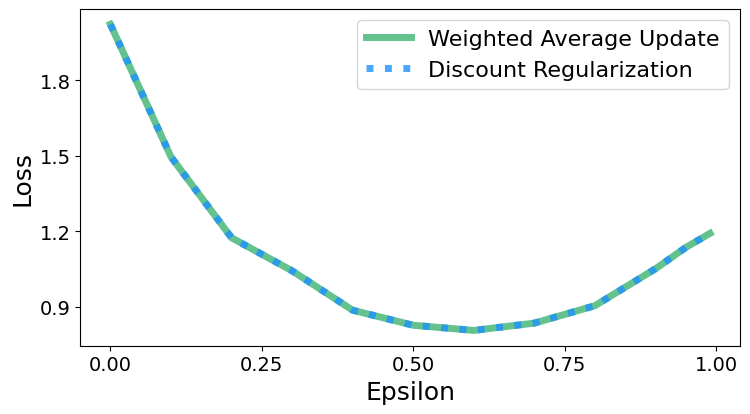

In [ ]:
epsilon_list = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.99]
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(epsilon_list,mean_loss_eps,label = 'Weighted Average Update',alpha=.8,linewidth = 5.0,color='mediumseagreen')
ax.plot(epsilon_list,mean_loss_disc,label = 'Discount Regularization',alpha=.8,linewidth = 5.0,color='dodgerblue',linestyle='dotted')
ax.set_xlabel("Epsilon",fontsize=18)
ax.set_ylabel("Loss",fontsize=18)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=16)

fig.tight_layout(rect=[0.05, 0, 1, 0.85])
#plt.savefig('same_policies_modelfree.pdf')
plt.savefig('/content/gdrive/My Drive/RegularizationJournalPlots/same_policies_modelfree.pdf')